# AVA Dataset

In [1]:
epochs = 0
data_name = 'animal'
from models import Classifier as Model
weight_path = 'weights/{}_{}.pt'.format(data_name, Model.__name__)
weight_path

'weights/animal_Classifier.pt'

In [2]:
from data import AVA
import matplotlib.pyplot as plt
from torchvision import transforms
import numpy as np
import torch

train_dataset = AVA('data/AVA_dataset/aesthetics_image_lists/animal_train.jpgl', 
              transform=transforms.Compose([
                  transforms.Resize(256),
                  transforms.CenterCrop(256),
                  transforms.ToTensor()
              ]))

test_dataset = AVA('data/AVA_dataset/aesthetics_image_lists/animal_test.jpgl', 
              transform=transforms.Compose([
                  transforms.Resize(256),
                  transforms.CenterCrop(256),
                  transforms.ToTensor()
              ]))

### Toggle cell below for sample debugging

In [3]:
train_loader = torch.utils.data.DataLoader(train_dataset,
    batch_size=128, shuffle=True, num_workers=2)
    
test_loader = torch.utils.data.DataLoader(test_dataset,
    batch_size=128, shuffle=True, num_workers=2)

In [4]:
an_item = test_dataset[0]
an_img = an_item[0]
a_label = an_item[1]

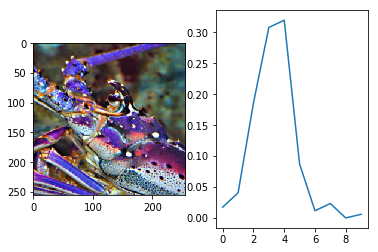

In [5]:
plt.subplot(1,2,1)
plt.imshow(an_img.numpy().transpose((1,2,0)))
plt.subplot(1,2,2)
plt.plot(a_label.numpy())

# Model

In [6]:
import torch
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model(10)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

### Load model

In [ ]:
import os

if os.path.exists(weight_path):
    model.load_state_dict(torch.load(weight_path))

In [14]:
len(train_loader.dataset), len(test_loader.dataset)

(2479, 2484)

In [8]:
from tqdm import tqdm

In [9]:
def train(epoch):
    model.train()
    model.to(device)
    total_loss = 0
    for data, labels in tqdm(train_loader):
        optimizer.zero_grad()
        data = data.to(device)
        labels = labels.to(device)
        
        preds = model(data)
        
        log_preds = preds.log()
        loss = F.kl_div(log_preds, labels, reduction='sum')
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    avg_loss = total_loss / len(train_loader.dataset)
    return avg_loss
    
def test(epoch):
    model.eval()
    model.to(device)
    total_loss = 0
    for data, labels in tqdm(test_loader):
        data = data.to(device)
        labels = labels.to(device)

        preds = model(data)
        
        log_preds = preds.log()
        loss = F.kl_div(log_preds, labels, reduction='sum')
        total_loss += loss.item()
        
    avg_loss = total_loss / len(test_loader.dataset)
    return avg_loss

CPU times: user 20 ms, sys: 8 ms, total: 28 ms
Wall time: 26.8 ms


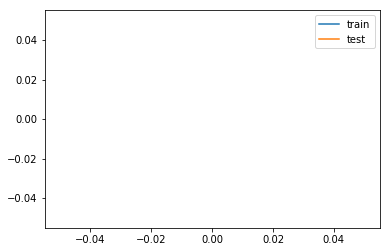

In [10]:
%%time
train_losses = []
test_losses = []
for e in range(epochs):
    train_loss = train(e)
    train_losses.append(train_loss)
    
    test_loss = test(e)
    test_losses.append(test_loss)
    
    print("Epoch {} Train Loss {:.2f} Test Loss {:.2f}".format(e, train_loss, test_loss))
    

plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.legend()

### Save model

In [ ]:
torch.save(model.state_dict(), weight_path)

# Evaluate

In [11]:
model.eval()
torch.set_grad_enabled(False)

In [12]:
def compute_mean_scores(batch_norm_votes):
    batch_size = batch_norm_votes.shape[0]
    weights = torch.arange(10, dtype=torch.float).view(1, 10) + 1
    broadcaster = torch.arange(batch_size).view(-1, 1)
    weights, _ = torch.broadcast_tensors(weights, broadcaster)
    
    weighted_votes = batch_norm_votes * weights
    means = weighted_votes.sum(dim=1)
    return means

100%|██████████| 20/20 [00:43<00:00,  2.16s/it]


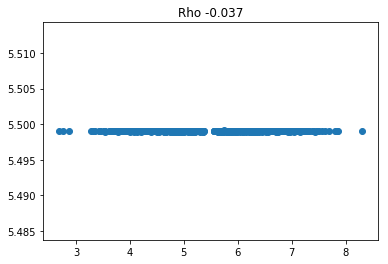

In [13]:
from scipy.stats import spearmanr
model.to(device)
true_scores = []
pred_scores = []
for data, labels in tqdm(test_loader):
    data = data.to(device)
    labels = labels.to(device)
    preds = model(data)
    
    label_scores = compute_mean_scores(labels.cpu())
    batch_pred_scores = compute_mean_scores(preds.cpu())
    for i in range(len(label_scores)):
        true_scores.append(label_scores[i].item())
        pred_scores.append(batch_pred_scores[i].item())

rho, _ = spearmanr(true_scores, pred_scores)
plt.title('Rho {:.3f}'.format(rho))
plt.scatter(true_scores, pred_scores)